# Importações

In [8]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import json
import cv2
import torch
import os.path as osp
import glob
import torchvision
import matplotlib.pyplot as plt


# Definição da classe UNetVgg

In [9]:
# Definição da classe UNetVgg
from torchvision.models import VGG16_Weights

class UNetVgg(torch.nn.Module):
    """
    BorderNetwork is a NN that aims to detected border and classify occlusion.
    The architecture is a VGG without the last pool layer. After that we 
    have two paths, one for regression and one for classification (occlusion).
    """
    
    def __init__(self, nClasses):
        super(UNetVgg, self).__init__()
 
        vgg16pre = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.vgg0 = torch.nn.Sequential(*list(vgg16pre.features.children())[:4])
        self.vgg1 = torch.nn.Sequential(*list(vgg16pre.features.children())[4:9])
        self.vgg2 = torch.nn.Sequential(*list(vgg16pre.features.children())[9:16])
        self.vgg3 = torch.nn.Sequential(*list(vgg16pre.features.children())[16:23])
        self.vgg4 = torch.nn.Sequential(*list(vgg16pre.features.children())[23:30])
        
        
        self.smooth0 = torch.nn.Sequential(
                torch.nn.Conv2d(128, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth1 = torch.nn.Sequential(
                torch.nn.Conv2d(256, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(64, 64, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth2 = torch.nn.Sequential(
                torch.nn.Conv2d(512, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        self.smooth3 = torch.nn.Sequential(
                torch.nn.Conv2d(1024, 256, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True),
                torch.nn.Conv2d(256, 256, kernel_size=(3,3), stride=1, padding=(1, 1)),
                torch.nn.ReLU(True)
                )
        
        
        self.final = torch.nn.Conv2d(64, nClasses, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        Args:
            x (torch.tensor): A tensor of size (batch, 3, H, W)
        Returns:
            reg_out (torch.tensor): A tensor with results of the regression (batch, 4).
            cls_out (torch.tensor): A tensor with results of the classification (batch, 2).
        """
        
        feat0 = self.vgg0(x)
        feat1 = self.vgg1(feat0)
        feat2 = self.vgg2(feat1)
        feat3 = self.vgg3(feat2)
        feat4 = self.vgg4(feat3)
        
        _,_,H,W = feat3.size()
        up3 = torch.nn.functional.interpolate(feat4, size=(H,W), mode='bilinear', align_corners=False)
        concat3 = torch.cat([feat3, up3], 1)
        end3 = self.smooth3(concat3)
        
        _,_,H,W = feat2.size()
        up2 = torch.nn.functional.interpolate(end3, size=(H,W), mode='bilinear', align_corners=False)
        concat2 = torch.cat([feat2, up2], 1)
        end2 = self.smooth2(concat2)
        
        _,_,H,W = feat1.size()
        up1 = torch.nn.functional.interpolate(end2, size=(H,W), mode='bilinear', align_corners=False)
        concat1 = torch.cat([feat1, up1], 1)
        end1 = self.smooth1(concat1)
        
        _,_,H,W = feat0.size()
        up0 = torch.nn.functional.interpolate(end1, size=(H,W), mode='bilinear', align_corners=False)
        concat0 = torch.cat([feat0, up0], 1)
        end0 = self.smooth0(concat0)
        
        return self.final(end0)
    
    
    @staticmethod
    def eval_net_with_loss(model, inp, gt, class_weights, device):
        """
        Evaluate network including loss.
        
        Args:
            model (torch.nn.Module): The model.
            inp (torch.tensor): A tensor (float32) of size (batch, 3, H, W)
            gt (torch.tensor): A tensor (long) of size (batch, 1, H, W) with the groud truth (0 to num_classes-1).
            class_weights (list of float): A list with len == num_classes.
            device (torch.device): device to perform computation
            
        Returns:
            out (torch.tensor): Network output.
            loss (torch.tensor): Tensor with the total loss.
                
        """
        weights = torch.from_numpy(np.array(class_weights, dtype=np.float32)).to(device)
        out = model(inp)
        
        softmax = torch.nn.functional.log_softmax(out, dim = 1)
        loss = torch.nn.functional.nll_loss(softmax, gt, ignore_index=-1, weight=weights)
            
        return (out, loss)
    
    @staticmethod
    def get_params_by_kind(model, n_base = 7):
    
        base_vgg_bias = []
        base_vgg_weight = []
        core_weight = []
        core_bias = []
    
        for name, param in model.named_parameters():
            if 'vgg' in name and ('weight' in name or 'bias' in name):
                vgglayer = int(name.split('.')[-2])
                
                if vgglayer <= n_base:
                    if 'bias' in name:
                        print('Adding %s to base vgg bias.' % (name))
                        base_vgg_bias.append(param)
                    else:
                        base_vgg_weight.append(param)
                        print('Adding %s to base vgg weight.' % (name))
                else:
                    if 'bias' in name:
                        print('Adding %s to core bias.' % (name))
                        core_bias.append(param)
                    else:
                        print('Adding %s to core weight.' % (name))
                        core_weight.append(param)
                        
            elif ('weight' in name or 'bias' in name):
                if 'bias' in name:
                    print('Adding %s to core bias.' % (name))
                    core_bias.append(param)
                else:
                    print('Adding %s to core weight.' % (name))
                    core_weight.append(param)
                    
        return (base_vgg_weight, base_vgg_bias, core_weight, core_bias)
    
# End class

# Declarações Variavies e outras configurações

In [10]:
# Variável que define se as figuras são exibidas no console ou salvas em um arquivo
plt_show = False
plt_savefig = False

# Configuração do dispositivo CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print(f'CUDA disponível: {cuda_available}')

if cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    vram_total = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)  # Convertendo para GB
    vram_available = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convertendo para GB
    print(f'Nome da GPU: {gpu_name}')
    print(f'VRAM Total: {vram_total:.2f} GB')

# Caminho do diretório Dataset
directory = os.path.abspath(os.path.join(os.getcwd(), '..\\..')) + r'\dataset'
print(f'Diretório do Projeto {directory}.')
if not os.path.exists(directory):
    os.makedirs(directory)
img_folder_val = directory + r'\\base\\Val'
img_folder_train = directory + r'\\base\\Train'
img_folder_test = directory + r'\\base\\Test'
save_dir = directory + r'\\result_UnetVgg\\'
if not os.path.exists(img_folder_val):
    os.makedirs(img_folder_val)
if not os.path.exists(img_folder_train):
    os.makedirs(img_folder_train)
if not os.path.exists(img_folder_test):
    os.makedirs(img_folder_test)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
## Imagens Segmentadas
img_folder_train_segmentadas = directory + r'\\segmentadas\\train\\'
img_folder_val_segmentadas = directory + r'\\segmentadas\\val\\'
img_folder_test_segmentadas = directory + r'\\segmentadas\\test\\'
if not os.path.exists(img_folder_train_segmentadas):
    os.makedirs(img_folder_train_segmentadas)
if not os.path.exists(img_folder_val_segmentadas):
    os.makedirs(img_folder_val_segmentadas)
if not os.path.exists(img_folder_test_segmentadas):
    os.makedirs(img_folder_test_segmentadas)
    
# Local onde o Modelo será salvo
model_file_name = save_dir + 'model_u-net-VGG16-IMAGENET1K_V1.pth'

# Configurações do treinamento
resolution_input = (640, 480)  # Tamanho de entrada
patience = 30
plot_val = True
plot_train = True
max_epochs = 100
class_weights = [1, 1, 1]
nClasses = 3

# Mapeamento de classes e cores
class_to_color = {'Doenca': (255, 0, 0), 'Solo': (0, 0, 255), 'Saudavel': (0, 255, 255)}
class_to_id = {'Doenca': 0, 'Solo': 1, 'Saudavel': 2}
id_to_class = {v: k for k, v in class_to_id.items()}


CUDA disponível: True
Nome da GPU: NVIDIA GeForce RTX 4070
VRAM Total: 11.99 GB
Diretório do Projeto c:\git\image-segmentation\dataset.


# Segmentação

In [11]:
# Definição do Dataset
class SegmentationDataset(Dataset):
    """Segmentation dataset loader."""

    def __init__(self, json_folder, img_folder, is_train, class_to_id, resolution_input=(640, 480), augmentation=False, transform=None):
        self.gt_file_list = glob.glob(osp.join(json_folder, '*.json'))
        self.total_samples = len(self.gt_file_list)
        self.img_folder = img_folder
        self.is_train = is_train
        self.transform = transform
        self.augmentation = augmentation
        self.resolution = resolution_input
        self.class_to_id = class_to_id
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        gt_file = self.gt_file_list[idx]
        img_number_str = osp.splitext(osp.basename(gt_file))[0]
        
        # Verificação de existência de arquivos
        if not osp.exists(gt_file):
            raise FileNotFoundError(f"Arquivo JSON não encontrado: {gt_file}")
        
        # Extrair o nome da imagem considerando que o nome da classe está no meio do nome do arquivo
        img_path = osp.join(self.img_folder, img_number_str + '.JPG')
        
        if not osp.exists(img_path):
            raise FileNotFoundError(f"Imagem não encontrada: {img_path}")
        
        gt_json = json.load(open(gt_file, 'r'))
        img_np = cv2.imread(img_path, cv2.IMREAD_IGNORE_ORIENTATION + cv2.IMREAD_COLOR)
        
        if img_np is None:
            raise FileNotFoundError(f"Imagem não encontrada: {img_path}")
        
        original_shape = img_np.shape
        img_np = cv2.resize(img_np, (self.resolution[0], self.resolution[1]))[..., ::-1]
        img_np = np.ascontiguousarray(img_np)
        label_np = np.zeros((img_np.shape[0], img_np.shape[1]))
        label_np[...] = -1

        for shape in gt_json['shapes']:
            points_np = np.array(shape['points'], dtype=np.float64)
            points_np[:, 0] *= self.resolution[0] / original_shape[1]
            points_np[:, 1] *= self.resolution[1] / original_shape[0]
            points_np = np.round(points_np).astype(np.int64)
            points_np = points_np.reshape((-1, 1, 2))
            label = shape['label']
            if label not in self.class_to_id:
                raise KeyError(f"Label '{label}' não encontrado em class_to_id")
            label_np = cv2.fillPoly(label_np, [points_np], self.class_to_id[label])

        label_np = label_np.astype(np.int32)

        if self.is_train and self.augmentation:
            if np.random.rand() > 0.5:
                img_np = np.fliplr(img_np)
                label_np = np.fliplr(label_np)
                img_np = np.ascontiguousarray(img_np)
                label_np = np.ascontiguousarray(label_np)

        img_pt = img_np.astype(np.float32) / 255.0
        for i in range(3):
            img_pt[..., i] -= self.mean[i]
            img_pt[..., i] /= self.std[i]

        img_pt = img_pt.transpose(2, 0, 1)
        img_pt = torch.from_numpy(img_pt)
        label_pt = torch.from_numpy(label_np).long()

        sample = {'image': img_pt, 'gt': label_pt, 'image_original': img_np}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Treinamento do modelo

In [ ]:
# Inicializar listas para armazenar a perda e a precisão
train_losses = []
train_accuracies = []
val_accuracies = []

# Inicia o treinamento
train_dataset = SegmentationDataset(img_folder_train, img_folder_train, True, class_to_id, resolution_input, True, None)
print(f"Número de amostras no dataset de treinamento: {len(train_dataset)}")
print(f"Arquivos no dataset de treinamento: {os.listdir(img_folder_train)}")

val_dataset = SegmentationDataset(img_folder_val, img_folder_val, False, class_to_id, resolution_input, False, None)
print(f"Número de amostras no dataset de validação: {len(val_dataset)}")
print(f"Arquivos no dataset de validação: {os.listdir(img_folder_val)}")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)

if plot_train:
    for i_batch, sample_batched in enumerate(train_loader):
        image_np = np.squeeze(sample_batched['image_original'].cpu().numpy())
        gt = np.squeeze(sample_batched['gt'].cpu().numpy())
        
        color_label = np.zeros((resolution_input[1], resolution_input[0], 3))
        
        for key, val in id_to_class.items():
            color_label[gt == key] = class_to_color.get(val, [0, 0, 0])  # Provide a default color if key is missing
        
        plt.figure()
        plt.imshow((image_np / 255) * 0.5 + (color_label / 255) * 0.5)
        if plt_savefig: 
            plt.savefig(img_folder_train_segmentadas + "TRAIN_IMG_" + str(i_batch) + ".png")
        if plt_show: 
            plt.show()
        plt.close('all')        
        plt.figure()
        plt.imshow(color_label.astype(np.uint8))
        if plt_savefig: 
            plt.savefig(img_folder_train_segmentadas + "TRAIN_GT_" + str(i_batch) + ".png")
        if plt_show: 
            plt.show()
        plt.close('all')

model = UNetVgg(nClasses).to(device)

core_lr = 0.02
base_vgg_weight, base_vgg_bias, core_weight, core_bias = UNetVgg.get_params_by_kind(model, 7)

optimizer = torch.optim.SGD([{'params': base_vgg_bias, 'lr': 0.000001}, 
                             {'params': base_vgg_weight, 'lr': 0.000001},
                             {'params': core_bias, 'lr': core_lr},
                             {'params': core_weight, 'lr': core_lr, 'weight_decay': 0.0005}], momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.2)

best_val_acc = -1
best_epoch = 0

# Start training...
for epoch in range(max_epochs):
    
    print('Epoch %d starting...' % (epoch+1))
    
    lr_scheduler.step()
    
    model.train()
    
    mean_loss = 0.0
    
    n_correct = 0
    n_false = 0
    
    for i_batch, sample_batched in enumerate(train_loader):
    
    
        image = sample_batched['image'].to(device)
        gt = sample_batched['gt'].to(device)
    
        optimizer.zero_grad()
        output, total_loss = model.eval_net_with_loss(model, image, gt, class_weights, device)
        total_loss.backward()
        optimizer.step()
        
        mean_loss += total_loss.cpu().detach().numpy()
        
        # Measure accuracy
        
        gt = np.squeeze(sample_batched['gt'].cpu().numpy())
        
        label_out = torch.nn.functional.softmax(output, dim = 1)
        label_out = label_out.cpu().detach().numpy()
        label_out = np.squeeze(label_out)
        
        labels = np.argmax(label_out, axis=0)
        valid_mask = gt != -1
        curr_correct = np.sum(gt[valid_mask] == labels[valid_mask])
        curr_false = np.sum(valid_mask) - curr_correct
        n_correct += curr_correct
        n_false += curr_false
        
    mean_loss /= len(train_loader)
    train_acc = n_correct / (n_correct + n_false)
        
    print('Train loss: %f, train acc: %f' % (mean_loss, train_acc))
    # Armazenar a perda e a precisão de treinamento
    train_losses.append(mean_loss)
    train_accuracies.append(train_acc)    
    
    n_correct = 0
    n_false = 0
    
    
    for i_batch, sample_batched in enumerate(val_loader):
    
    
        image = sample_batched['image'].to(device)
        image_np = np.squeeze(sample_batched['image_original'].cpu().numpy())
        gt = np.squeeze(sample_batched['gt'].cpu().numpy())
        
    
        label_out = model(image)
        label_out = torch.nn.functional.softmax(label_out, dim = 1)
        label_out = label_out.cpu().detach().numpy()
        label_out = np.squeeze(label_out)
        
        labels = np.argmax(label_out, axis=0)
        
        if plot_val:
            
            color_label = np.zeros((resolution_input[1], resolution_input[0], 3))
            
            for key, val in id_to_class.items():
                color_label[labels == key] = class_to_color[val]
                
            plt.figure()
            plt.imshow((image_np/255) * 0.5 + (color_label/255) * 0.5)
            if plt_savefig: 
                plt.savefig(img_folder_val_segmentadas + "IMG_" + str(i_batch) + "_epoch_" + str(epoch) + ".png")
            if plt_show: 
                plt.show()
            
            plt.figure()
            plt.imshow(color_label.astype(np.uint8))
            if plt_savefig: 
                plt.savefig(img_folder_val_segmentadas + "GT_" + str(i_batch) + "_epoch_" + str(epoch) +  ".png")
            if plt_show: 
                plt.show()
        
        valid_mask = gt != -1
        curr_correct = np.sum(gt[valid_mask] == labels[valid_mask])
        curr_false = np.sum(valid_mask) - curr_correct
        n_correct += curr_correct
        n_false += curr_false    
        
    total_acc = n_correct / (n_correct + n_false)
    val_accuracies.append(total_acc)
    
    if best_val_acc < total_acc:
        best_val_acc = total_acc
        if epoch > 7:
            torch.save(model.state_dict(), model_file_name)
            print('Nova melhor conta de validação. Salvo... %f', epoch)
        best_epoch = epoch

    if (epoch - best_epoch) > patience:
        print(f"Terminando o treinamento, melhor conta de validação {best_val_acc:.6f}")
        break
    
    print('Validação Acc: %f -- Melhor Avaliação Acc: %f -- epoch %d.' % (total_acc, best_val_acc, best_epoch))


# Plotar os gráficos de perda e precisão

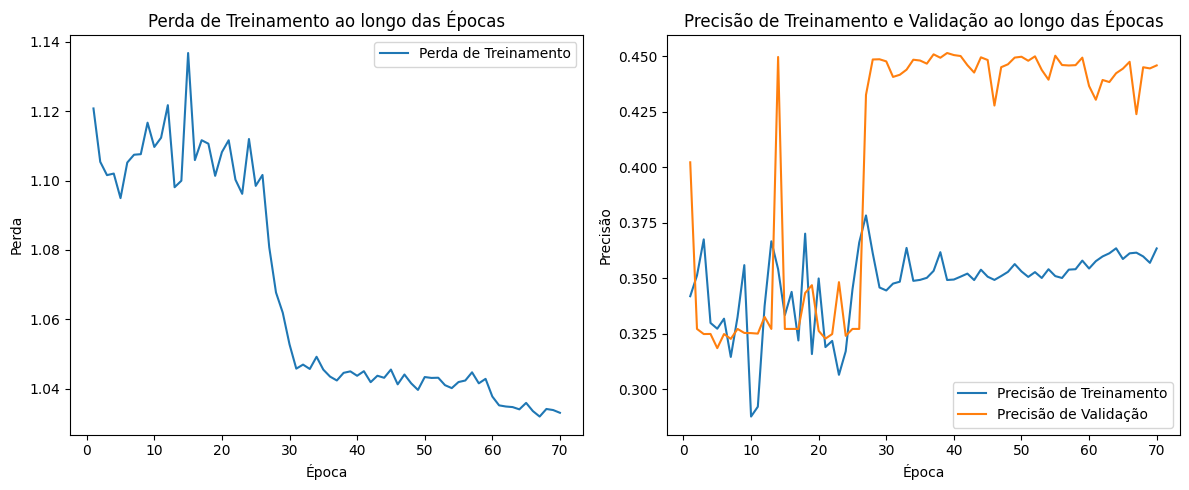

In [13]:
# Plotar os gráficos de perda e precisão
"""
    Inicialização das listas: train_losses, train_accuracies e val_accuracies são listas para armazenar a perda e a precisão de treinamento e validação em cada época.
    
    Armazenamento dos valores: Durante o loop de treinamento, a perda e a precisão são calculadas e armazenadas nas listas correspondentes.
    Plotagem dos gráficos: Após o loop de treinamento, os gráficos de perda e precisão são plotados usando matplotlib.

    Este código deve ser adicionado ao final do seu loop de treinamento no notebook para visualizar os resultados do treinamento ao longo das épocas.
"""

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Perda de Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de Treinamento ao longo das Épocas')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Precisão de Treinamento')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Precisão de Validação')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.title('Precisão de Treinamento e Validação ao longo das Épocas')
plt.legend()

plt.tight_layout()
plt.savefig(save_dir + 'result_model_segmentadas_unet_loss_accuracy.png')
plt.show()
plt.close('all')

# Inferência de dados

In [ ]:
## Configurações do treinamento
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

model = UNetVgg(nClasses)
#model.load_state_dict(torch.load(model_file_name))
model.load_state_dict(torch.load(model_file_name, weights_only=True))
model.eval()
print("Modelo carregado e pronto para uso.")
model.to(device)

img_list = glob.glob(osp.join(img_folder_val, '*.JPG'))
print(f"Imagens de teste: {len(img_list)}")

for img_path in img_list:
    img_np = cv2.imread(img_path, cv2.IMREAD_IGNORE_ORIENTATION + cv2.IMREAD_COLOR)
    img_np = cv2.resize(img_np, (resolution_input[0], resolution_input[1]))[..., ::-1]
    img_np = np.ascontiguousarray(img_np)
    
    img_pt = np.copy(img_np).astype(np.float32) / 255.0
    for i in range(3):
        img_pt[..., i] -= mean[i]
        img_pt[..., i] /= std[i]

    img_pt = img_pt.transpose(2, 0, 1)
    img_pt = torch.from_numpy(img_pt[None, ...]).to(device)

    label_out = model(img_pt)
    label_out = torch.nn.functional.softmax(label_out, dim=1)
    label_out = label_out.cpu().detach().numpy()
    label_out = np.squeeze(label_out)

    labels = np.argmax(label_out, axis=0)

    color_label = np.zeros((resolution_input[1], resolution_input[0], 3))

    for key, val in id_to_class.items():
        color_label[labels == key] = class_to_color[val]
        
    final_image = osp.basename(img_path)
    final_image = osp.splitext(final_image)[0]
    final_image = osp.join(img_folder_test_segmentadas, final_image)
    
    plt.figure()
    plt.imshow((img_np / 255) * 0.5 + (color_label / 255) * 0.5)
    plt.savefig(final_image + "RESULT_INFERENCIA_IMG_" + ".png")
    if plt_show:
        plt.show()
    plt.close('all')

    plt.figure()
    plt.imshow(color_label.astype(np.uint8))
    plt.savefig(final_image + "RESULT_INFERENCIA_GT_" + ".png")
    if plt_show:
        plt.show()
    plt.close('all')


Modelo carregado e pronto para uso.
Imagens de teste: 89
